In [58]:
import mediapipe as mp
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from matplotlib import pyplot as plt

In [3]:
# Set up MediaPipe Holistic
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [6]:
# Function to extract keypoints using MediaPipe Holistic
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [8]:
# Load ASL Alphabet dataset (downloaded from Kaggle)
DATA_PATH = "./dataset/asl_alphabet_train/asl_alphabet_train/"  # Change this to your dataset's local path
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [62]:
# Initialize empty lists to store data and labels
X_data, y_data = [], []

In [64]:
# Loop through each action (A-Z) to process images
for action in actions:
    action_folder = os.path.join(DATA_PATH, action)
    for filename in os.listdir(action_folder):
        img_path = os.path.join(action_folder, filename)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image with MediaPipe Holistic
        with mp_holistic.Holistic(static_image_mode=True) as holistic:
            results = holistic.process(image_rgb)
            if results.pose_landmarks or results.face_landmarks or results.left_hand_landmarks or results.right_hand_landmarks:
                keypoints = extract_keypoints(results)
                X_data.append(keypoints)
                y_data.append(action)

In [73]:
# Convert lists to NumPy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

In [75]:
# Normalize/Standardize the keypoints data to prevent NaN loss
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

In [77]:
# Encode labels
lb = LabelBinarizer()
y_data_encoded = lb.fit_transform(y_data)

In [79]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_encoded, test_size=0.2, random_state=42)

In [81]:
# Reshape data for CNN input (add a third dimension)
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

In [83]:
### Step 2: Build and Compile the Model

# LSTM-CNN hybrid model architecture
model = Sequential()

# 1D CNN Layer to extract spatial features from the keypoints
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# LSTM Layer to capture temporal patterns
model.add(LSTM(128, return_sequences=False, activation='relu'))

# Dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

# Use a lower learning rate and clip gradients to prevent NaN loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1627, 64)          256       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 813, 64)           0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 26)                1690      
                                                                 
Total params: 109018 (425.85 KB)
Trainable params: 109018 (425.85 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [87]:
### Step 3: Add Callbacks for Training

# Callbacks: Early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_asl_model.h5', monitor='val_loss', save_best_only=True)

In [89]:
### Step 4: Train the Model with Callbacks

# Training the model with early stopping and checkpointing
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=100,  # Feel free to adjust epochs based on your system's performance
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
695/695 [==============================] - 714s 1s/step - loss: nan - accuracy: 0.0225 - val_loss: nan - val_accuracy: 0.0207
Epoch 2/100
695/695 [==============================] - 703s 1s/step - loss: nan - accuracy: 0.0210 - val_loss: nan - val_accuracy: 0.0207
Epoch 3/100
695/695 [==============================] - 701s 1s/step - loss: nan - accuracy: 0.0210 - val_loss: nan - val_accuracy: 0.0207
Epoch 4/100
695/695 [==============================] - 695s 1000ms/step - loss: nan - accuracy: 0.0210 - val_loss: nan - val_accuracy: 0.0207
Epoch 5/100
695/695 [==============================] - 690s 992ms/step - loss: nan - accuracy: 0.0210 - val_loss: nan - val_accuracy: 0.0207
Epoch 6/100
695/695 [==============================] - 895s 1s/step - loss: nan - accuracy: 0.0210 - val_loss: nan - val_accuracy: 0.0207
Epoch 7/100
695/695 [==============================] - 1094s 2s/step - loss: nan - accuracy: 0.0210 - val_loss: nan - val_accuracy: 0.0207
Epoch 8/100
695/695 [=====

In [50]:
### Step 5: Evaluate and Visualize the Training Process

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

174/174 - 80s - loss: nan - accuracy: 0.0207 - 80s/epoch - 461ms/step

Test Accuracy: 2.07%


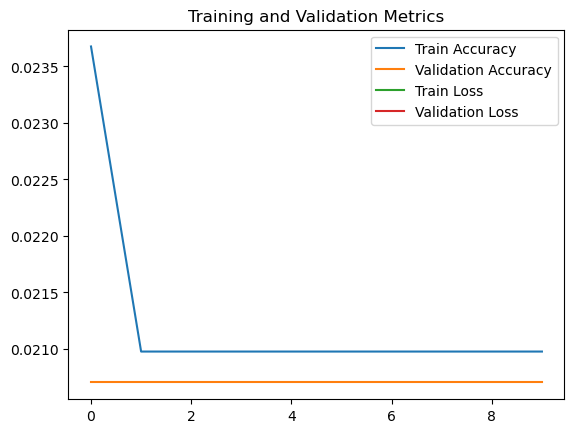

In [53]:
# Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Metrics')
plt.show()

In [ ]:
### Step 6: Convert the Model for Edge Devices

# Save the trained model in TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the TFLite model
with open('asl_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been saved as 'asl_model.tflite' for edge device deployment.")